In [1]:
%matplotlib inline
# color-blind friendly colors
red = '#e41a1c'
blue = '#377eb8'
green = '#4daf4a'
pink = '#f781bf'
brown = '#a65628'
purple = '#984ea3'
gray = '#999999'
yellow = '#dede00'
colors = [red, blue, green, pink, brown, purple, gray, yellow]

In [2]:
from halotools.empirical_models import PrebuiltHodModelFactory, HodModelFactory
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import SubhaloPhaseSpace

logmmin, logmmax = 10.6, 15.2
subocc_model = SubhaloPhaseSpace('satellites', np.logspace(logmmin, logmmax, 15))

baseline_model = PrebuiltHodModelFactory('cacciato09')
model = HodModelFactory(baseline_model_instance=baseline_model, 
                       satellites_profile=subocc_model)

model.populate_mock(CachedHaloCatalog(simname='bolplanck'))

In [3]:
model.mock.populate()

In [4]:
gals = model.mock.galaxy_table

low_mhost, high_mhost = 10**13.9, 10**14.1
mhost_mask = (gals['halo_mvir_host_halo'] > low_mhost) & (gals['halo_mvir_host_halo'] < high_mhost)
sample = gals[mhost_mask]

satmask = sample['gal_type'] == 'satellites'
sats = sample[satmask]
cens = sample[~satmask]

print("Number of satellites = {0}".format(len(sats)))
print("Number of centrals = {0}".format(len(cens)))

Number of satellites = 2302
Number of centrals = 309


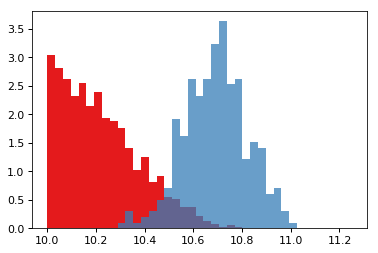

In [5]:
fig, ax = plt.subplots(1, 1)

num_lumbins = 40
__=ax.hist(np.log10(sats['luminosity']), 
           bins=np.linspace(model.threshold, 11.25, num_lumbins), normed=True, 
          color=red)
__=ax.hist(np.log10(cens['luminosity']), 
           bins=np.linspace(model.threshold, 11.25, num_lumbins), normed=True, 
           alpha=0.75, color=blue)

In [6]:
from halotools.empirical_models import randomly_resort

idx_sorted_mpeak = np.argsort(sats['halo_mpeak'])
idx_sorted_luminosity = np.argsort(sats['luminosity'])

sats['new_luminosity'] = 0.
sats['new_luminosity'][idx_sorted_mpeak] = sats['luminosity'][idx_sorted_luminosity]
sats['new_luminosity2'] = randomly_resort(sats['new_luminosity'], 0.1)

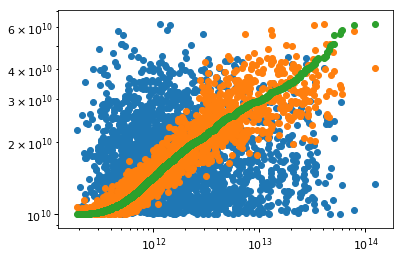

In [7]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.scatter(sats['halo_mpeak'], sats['luminosity'])
__=ax.scatter(sats['halo_mpeak'], sats['new_luminosity2'])
__=ax.scatter(sats['halo_mpeak'], sats['new_luminosity'])

In [40]:
import segregated_luminosity 
reload(segregated_luminosity)

<module 'segregated_luminosity' from 'segregated_luminosity.py'>

In [51]:
mhost_bins = np.logspace(11.5, 15, 15)
gals['new_luminosity1'] = segregated_luminosity.segregated_luminosities(gals, 0., mhost_bins=mhost_bins)
gals['new_luminosity2'] = segregated_luminosity.segregated_luminosities(gals, 0.25, mhost_bins=mhost_bins)
gals['new_luminosity3'] = segregated_luminosity.segregated_luminosities(gals, 0., mhost_bins=mhost_bins[10:])


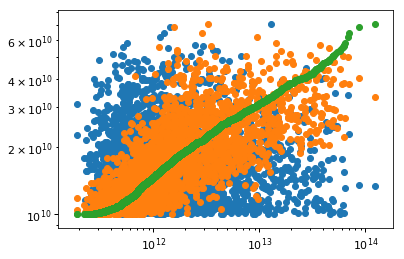

In [54]:
low_mhost, high_mhost = mhost_bins[10], mhost_bins[11]
mask = (gals['halo_mvir_host_halo'] >= low_mhost) & (gals['halo_mvir_host_halo'] < high_mhost)
satmask = mask*(gals['gal_type'] == 'satellites')
sample = gals[satmask]

new_luminosity = result[satmask]

fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.scatter(sample['halo_mpeak'], sample['luminosity'])
__=ax.scatter(sample['halo_mpeak'], sample['new_luminosity2'])
__=ax.scatter(sample['halo_mpeak'], sample['new_luminosity1'])


In [55]:
from halotools.mock_observables import tpcf, return_xyz_formatted_array

In [65]:
pos0 = return_xyz_formatted_array(gals['x'], gals['y'], gals['z'], 
                                 mask = gals['luminosity'] < 10**10.25)
pos1 = return_xyz_formatted_array(gals['x'], gals['y'], gals['z'], 
                                 mask = gals['new_luminosity1'] < 10**10.25)
pos2 = return_xyz_formatted_array(gals['x'], gals['y'], gals['z'], 
                                 mask = gals['new_luminosity2'] < 10**10.25)
pos3 = return_xyz_formatted_array(gals['x'], gals['y'], gals['z'], 
                                 mask = gals['new_luminosity3'] < 10**10.25)

In [110]:
rbins = np.logspace(-1.25, 1.25, 25)
rmids = 0.5*(rbins[:-1] + rbins[1:])

xi0 = tpcf(pos0, rbins, period=250)
xi1 = tpcf(pos1, rbins, period=250)
xi2 = tpcf(pos2, rbins, period=250)
xi3 = tpcf(pos3, rbins, period=250)

In [111]:
fracdiff1 = (xi1 - xi0)/xi0
fracdiff2 = (xi2 - xi0)/xi0
fracdiff3 = (xi3 - xi0)/xi0

from scipy.signal import savgol_filter

fracdiff1_smooth = savgol_filter(fracdiff1, 11, 3)
fracdiff2_smooth = savgol_filter(fracdiff2, 11, 3)
fracdiff3_smooth = savgol_filter(fracdiff3, 11, 3)

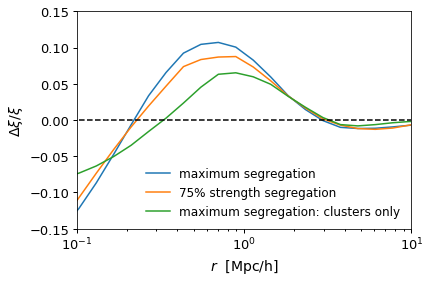

In [113]:
fig, ax = plt.subplots(1, 1)

xscale = ax.set_xscale('log')
xlim = ax.set_xlim(xmin = 0.1, xmax=10)
ylim = ax.set_ylim(ymin=-0.15, ymax=0.15)

ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')
plt.xticks(fontsize=13); plt.yticks(fontsize=13) 

__=ax.plot(rmids, fracdiff1_smooth, label='maximum segregation')
__=ax.plot(rmids, fracdiff2_smooth, label='75% strength segregation')
__=ax.plot(rmids, fracdiff3_smooth, label='maximum segregation: clusters only')
__=ax.plot(np.logspace(-2, 2, 100), np.zeros(100), '--', color='k')


xlabel = ax.set_xlabel(r'$r$  [Mpc/h]', size=14)
ylabel = ax.set_ylabel(r'$\Delta\xi / \xi$', size=14)
legend = ax.legend(loc='best', fontsize=12)

fig.savefig('mass_segregation_variations.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')
